In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn import metrics

In [2]:
# 读入数据
data = pd.read_csv("./bank-additional/bank-additional-full.csv", sep=";")

In [4]:
# 数据浏览
data.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# 数据大小
data.shape

(41188, 21)

In [6]:
# 数据预处理
# 预测列 yes no 变为 1 0
data['y'].replace(['yes', 'no'], [1, 0], inplace=True)
# one-hot处理
data_one_hot = pd.get_dummies(data)

In [20]:
# 采用四个分类模型
# KNN Classifier
def knn_classifier(train_x, train_y):
    from sklearn.neighbors import KNeighborsClassifier
    model = KNeighborsClassifier()
    model.fit(train_x, train_y)
    return model


# Logistic Regression Classifier
def logistic_regression_classifier(train_x, train_y):
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(penalty='l2')
    model.fit(train_x, train_y)
    return model


# Random Forest Classifier
def random_forest_classifier(train_x, train_y):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=50)
    model.fit(train_x, train_y)
    return model


# GBDT(Gradient Boosting Decision Tree) Classifier
def gradient_boosting_classifier(train_x, train_y):
    from sklearn.ensemble import GradientBoostingClassifier
    model = GradientBoostingClassifier(n_estimators=100)
    model.fit(train_x, train_y)
    return model

test_classifiers = ['KNN', 'LR', 'RF', 'GBDT']
classifiers = {
              'KNN':knn_classifier,
               'LR':logistic_regression_classifier,
               'RF':random_forest_classifier,
             'GBDT':gradient_boosting_classifier
}

In [21]:
# 预测函数
def predict(model, X, y):
    y_pred = model.predict(X)
    y_predprob = model.predict_proba(X)[:,1]
    acc = metrics.accuracy_score(y.values, y_pred)

    auc =  metrics.roc_auc_score(y, y_predprob)
#     print("Accuracy : %.4g" % metrics.accuracy_score(y.values, y_pred))
#     print("AUC Score : %f" % metrics.roc_auc_score(y, y_predprob))
    return acc, auc

In [22]:
# 分割data，按不同比例分成训练集与测试集
# 比例有0.1，,02, 0.3，...,0.9
# 对于每个模型以及训练集与测试集，分别计算Accuracy与AUC值
# 结果保存在result中
result = {}

for classifier in classifiers:
    result[classifier] = {}
    result[classifier]['acc'] = []
    result[classifier]['auc'] = []

    for i in np.arange(0.1,1,0.1):
        train, test = train_test_split(data_one_hot, test_size=1 - i,
                                            random_state=123)
        train_x = train.drop('y', axis=1)
        train_y = train['y']
        test_x = test.drop('y', axis=1)
        test_y = test['y']

#         print('******************* %s %.4f ********************' %(classifier,i))
        model = classifiers[classifier](train_x, train_y)
        acc, auc = predict(model, test_x, test_y)
        result[classifier]['acc'].append(acc)
        result[classifier]['auc'].append(auc)

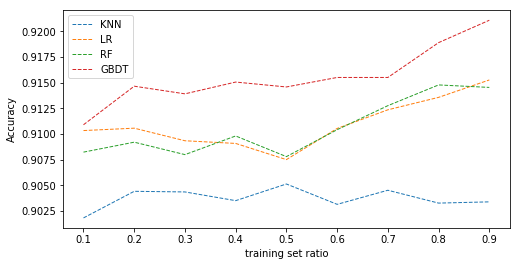

In [25]:
import matplotlib.pyplot as plt
#显示Accuracy结果图
x = np.arange(0.1,1,0.1)
plt.figure(figsize=(8,4)) #创建绘图对象
for i in result:
    y = result[i]['acc']
    plt.plot(x,y,"--",linewidth=1,label = i)   #在当前绘图对象绘图

plt.xlabel("training set ratio") #X轴标签
plt.ylabel("Accuracy")  #Y轴标签
plt.legend()

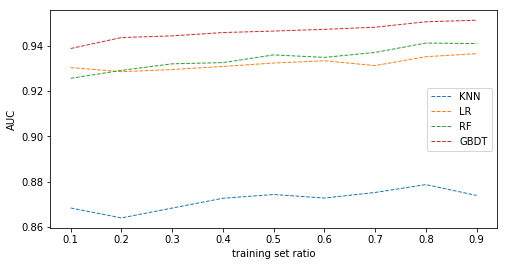

In [24]:
#显示Accuracy结果图
x = np.arange(0.1,1,0.1)
plt.figure(figsize=(8,4)) #创建绘图对象
for i in result:
    y = result[i]['auc']
    plt.plot(x,y,"--",linewidth=1,label = i)   #在当前绘图对象绘图

plt.xlabel("training set ratio") #X轴标签
plt.ylabel("AUC")  #Y轴标签
plt.legend()